In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential  # ✅ Corrected
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN  # ✅ Corrected
from tensorflow.keras.layers import Dense, Activation, Dropout  # ✅ Corrected
from tensorflow.keras.layers import Embedding  # ✅ Corrected
from tensorflow.keras.layers import BatchNormalization  # ✅ Correct

from tensorflow.keras.utils import to_categorical  # ✅ Corrected
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer  # ✅ Correct
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


E0000 00:00:1739387069.062232      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [4]:
import pandas as pd
dtrain = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
dval = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
dtest = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu ='local')
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    print('TPU is not active')
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1739387105.663201      10 service.cc:148] XLA service 0x578920fbf5c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739387105.663250      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1739387105.663254      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1739387105.663258      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1739387105.663260      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1739387105.663263      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1739387105.663266      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1739387105.663269      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1739387105.663272      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [7]:
print("REPLICAS: ", strategy.num_replicas_in_sync)
core = strategy.num_replicas_in_sync

REPLICAS:  8


In [8]:
dtrain

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [9]:
dtest

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr
...,...,...,...
63807,63807,"No, non risponderò, come preannunciato. Prefer...",it
63808,63808,"Ciao, I tecnici della Wikimedia Foundation sta...",it
63809,63809,innnazitutto ti ringrazio per i ringraziamenti...,it
63810,63810,Kaç olumlu oy gerekiyor? Şu an 7 oldu. Hayır...,tr


# Data Preprocessing: 

**Consider this example as binary classification with only toxic**

In [10]:
#Limitting the data
dtrain = dtrain.loc[:12000,:]

In [11]:
dtrain = dtrain[['id','comment_text','toxic']]
dtrain.head(5)

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [12]:
each_len = []

for k in dtrain['comment_text']:
    each_len.append(len(k.split(' ')))
    
dtrain['comment_len'] = each_len

In [13]:
dtrain_sorted = dtrain.groupby('comment_len')[['comment_text']].max().sort_values(by='comment_len', ascending=False).reset_index()

dtrain_sorted

,comment_len,comment_text
0,1400,do go fuck off bastard\nDo Yyou Have a life?\n...
1,1335,"""Contents of the library (objects and function..."
2,1227,"Ahh, Hello Witzeman \n\n203.92.84.161 \nSymbo..."
3,1198,I am going to kill you. I am going to murder y...
4,1108,HATE YOU HATE YOU HATE YOU HATE YOU HATE YOU H...
...,...,...
564,5,}} to user talk pages.}}\n\n{{Clear
565,4,}}\n{{WikiProject University of Oxford|class=B...
566,3,with aristocratic connections
567,2,|importance=\n|attention=\n|collaboration-cand...


In [ ]:
#print(dtrain_sorted.iloc[0]['comment_text'])
#print(dtrain_sorted.iloc[0]['comment_len'])

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def roc_auc_cal(pred,y):
    a=roc_auc_score(y, pred)
    return a

In [ ]:
#EXAMPLE
'''
# Simulated dataset
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

print(roc_auc_cal(y_scores,y_true))  ---- 0.75
'''

In [16]:
dtrain

,id,comment_text,toxic,comment_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,42
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,18
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,112
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,13
...,...,...,...,...
11996,1fc25487b9b9187f,February 2006 (UTC)\n\nThank you for fixing th...,0,51
11997,1fc3e5540e2605d1,Erased another silly message.,0,4
11998,1fc4c99c34cf0e07,"""\n\n Helly Jimmy, well; fuck you. \n\nAccordi...",1,129
11999,1fc8d9f16da8cccc,"Why don't you run cry to your mommy, little As...",1,10


In [17]:
#Converting text to lowercase:
import re
def convt_lower(data):
    tmp = []
    for e in data:
        tmp.append(e.lower())
    return tmp

def remove_specialchar(data):
    tmp = []
    for e in data:
        e = e.replace('\n',' ')
        tmp.append(re.sub(r'[^a-zA-Z0-9\s]', '', e))
    return tmp


In [18]:
comment_lc = convt_lower(dtrain['comment_text'])
comment_punc = remove_specialchar(comment_lc)
dtrain['comment_pro']=comment_punc

**Takeaways here:**

> I need to tokenizer them then i am going to list it into sequence. For doing that, I splitted the data into train and test. But only train data goes to Tokenizer.fit_on_text. If I put train and test data together, tokenization process would be done by considering test data which means the model would see the test data. but it should not see. test data should be unseen.

In [19]:
dtrain['comment_pro'].apply(lambda x:len(str(x).split())).max()

np.int64(1403)

In [20]:
#first split the data:
y = dtrain['toxic']
x = dtrain['comment_pro']
x_train,x_test,y_train,y_test = train_test_split(x.values,y.values,random_state=42,test_size=0.25, shuffle=True)

maxlen = 2000
#Initialize the tokenizer
token = Tokenizer(num_words=maxlen, oov_token="<OOV>") 
token.fit_on_texts(x_train)
vocab_size=token.word_index

#Apply the tokenizer here:
x_train_seq = token.texts_to_sequences(x_train) 
x_test_seq = token.texts_to_sequences(x_test)   #Truncation just so that max len of data is 2000 words

#Truncation did not take place before. I will to it now!
for e in x_train_seq:
    if len(e)>2000:
        print(len(e))
        print('blinked!')
        break

x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen, padding='pre', truncating='pre') #post or pre
x_test_pad = pad_sequences(x_test_seq, maxlen=maxlen, padding='pre', truncating='pre') #post or pre

#now check whether the truncating is done succesfully:
checker = True
for e in x_train_pad:
    if len(e) > 2000:
        print('blinked!')
        checker == False
if checker == True:
    print('truncating is applied sucessfully')
else:
    print('there is a problem in truncating')
    

truncating is applied sucessfully


In [24]:
i = 0
for k,v in vocab_size.items():
    print(k,v)
    i+=1
    if i == 10:
        break
print('the number of vocabulary',len(vocab_size))

<OOV> 1
the 2
to 3
of 4
and 5
a 6
i 7
you 8
is 9
that 10
the number of vocabulary 38409


**RNN(Embedding layer needs 3 input):**
- num_vocab
- embedding dim
- inp_len

**Takeaways_1:** (num_vocab)

> Embedding layer needs to know how many words exists in the vocabulary to assign embedding properly. Here created an matrix for the entire vocabulary. Thats why we need make the matrix prepare for how many different inputs will come.
>
**Takeaways_2:** (embedding_dim)

> Embedding layer need to know each token has how many feature vectors. When you assign lets say 100, each token will have 100 different embedding vectors that refers to features.
> Bigger vector of feature, slower training time, better results (also overfiting risk)
> Lesser vector of feature, faster training time, worse results 

In [22]:
x_train_pad

array([[   0,    0,    0, ...,    1,  500,  175],
       [   0,    0,    0, ..., 1159,    1, 1158],
       [   0,    0,    0, ...,  100,    7,   73],
       ...,
       [   0,    0,    0, ...,  899,    1,    1],
       [   0,    0,    0, ...,  800,    1,    1],
       [   0,    0,    0, ...,  119,  168,    1]], dtype=int32)

# Basic RNN

In [28]:
from tensorflow.keras.optimizers import Adam

loss = 'binary_crossentropy'

with strategy.scope():
    optimizer = Adam(learning_rate=1e-5,clipnorm=1.0)

    model = Sequential()

    model.add(Embedding(len(vocab_size)+1,300,input_length = maxlen)) #input_dim,output_dim(embedding_dim),inp_len
    model.add(BatchNormalization())
    model.add(SimpleRNN(100))
    model.add(Dense(1,activation='sigmoid'))

    model.build(input_shape=(None, 2000))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics =['accuracy'])
model.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1739387183.319840      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2000, 300)      │    11,523,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2000, 300)      │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,564,401 (44.11 MB)

 Trainable params: 11,563,801 (44.11 MB)

 Non-trainable params: 600 (2.34 KB)

> **Takeaways**:
> Somehow the results go to nan value. It may be gradient exploding! (cause1) -- i will check it
> also decrease the batch size

In [30]:
history_basicRNN = model.fit(x_train_pad,y_train,epochs = 20, batch_size=64*strategy.num_replicas_in_sync,validation_data = (x_test_pad,y_test))

Epoch 1/20


I0000 00:00:1739387217.463310      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9207666945900646300
I0000 00:00:1739387217.901009     942 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18074154417551500322), session_name()
I0000 00:00:1739387221.770072     942 tpu_compile_op_common.cc:245] Compilation of 18074154417551500322 with session name  took 3.869006483s and succeeded
I0000 00:00:1739387221.777303     942 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18074154417551500322), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9207666945900646300", property.function_library_fingerprint = 15297117281634788694, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

17/18 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8402 - loss: 0.4168

I0000 00:00:1739387290.043652     932 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6174410669186683677), session_name()
I0000 00:00:1739387294.305524     932 tpu_compile_op_common.cc:245] Compilation of 6174410669186683677 with session name  took 4.261814552s and succeeded
I0000 00:00:1739387294.312778     932 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6174410669186683677), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9207666945900646300", property.function_library_fingerprint = 15297117281634788694, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "37,2000,;37,;", property.guaranteed_constants_size = 0, embedding_partiti

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8402 - loss: 0.4168

I0000 00:00:1739387298.856245      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6607116219480150626
I0000 00:00:1739387299.109247     912 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9473288877260290126), session_name()
I0000 00:00:1739387299.903948     912 tpu_compile_op_common.cc:245] Compilation of 9473288877260290126 with session name  took 794.654984ms and succeeded
I0000 00:00:1739387299.906284     912 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9473288877260290126), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6607116219480150626", property.function_library_fingerprint = 2590309085361956550, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.8402 - loss: 0.4168 - val_accuracy: 0.5850 - val_loss: 0.6803
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.8927 - loss: 0.3696 - val_accuracy: 0.6361 - val_loss: 0.6645
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.8987 - loss: 0.3384 - val_accuracy: 0.6738 - val_loss: 0.6484
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.8923 - loss: 0.3530 - val_accuracy: 0.7120 - val_loss: 0.6326
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8947 - loss: 0.3554 - val_accuracy: 0.7525 - val_loss: 0.6155
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.9180 - loss: 0.2882 - val_accuracy: 0.7785 - val_loss: 0.5986
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.8951 - loss: 0.3374 - val_accuracy: 0.8123 - val_loss: 0.5815
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.9105 - loss: 0.3070 - val_accuracy: 0.8445 - val_loss: 0.5632
Epo

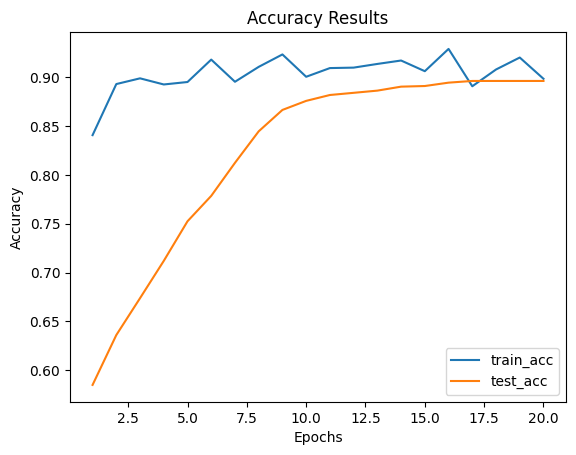

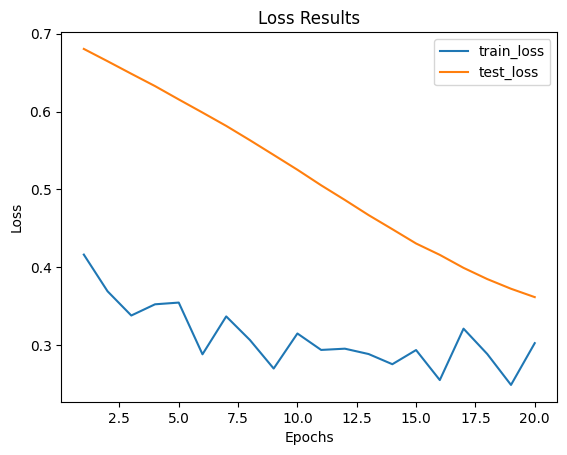

In [31]:
train_acc = history_basicRNN.history['accuracy']
test_acc = history_basicRNN.history['val_accuracy']
train_loss = history_basicRNN.history['loss']
test_loss = history_basicRNN.history['val_loss']

epoch = range(1,len(train_acc)+1) # From  1 to epoch number


plt.plot(epoch,train_acc ,label ='train_acc')
plt.plot(epoch,test_acc ,label ='test_acc')
plt.title('Accuracy Results')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epoch,train_loss ,label ='train_loss')
plt.plot(epoch,test_loss ,label ='test_loss')
plt.title('Loss Results')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## GloVe Embedding
> instead of random embedding of feature vector, we can inherit the feature information that trained before and also trained in more large data.
> GloVe, Word2Vec 

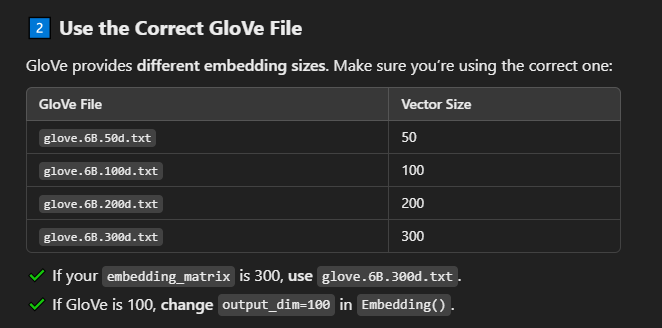

In [34]:
#previous model: model.add(Embedding(vocab_size+1,300,input_length = maxlen)) #input_dim, embedding_dim or output_dim, input_len
embedding_dim = 301

glove = '/kaggle/input/glove840b300dtxt/glove.840B.300d.txt'

In [35]:
#https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
embeddings_dict = {}
with open(glove, 'r',encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

2196018it [02:07, 17193.54it/s]


## Matching the data with glove embeddings

In [37]:
#let me remember:
i = 0
for k,v in vocab_size.items():
    print(k,v)
    i+=1
    if i == 10:
        break

<OOV> 1
the 2
to 3
of 4
and 5
a 6
i 7
you 8
is 9
that 10


In [38]:
len(vocab_size)

38409

In [39]:
embedding_vector = np.zeros((len(vocab_size)+1,300)) #creating empty array
#filling them with pretrained values:

for k,i in tqdm(vocab_size.items()):
    arr_value = embeddings_dict.get(k)
    if arr_value is not None:
        embedding_vector[i] = arr_value

100%|██████████| 38409/38409 [00:00<00:00, 269676.86it/s]


In [40]:
embeddings_dict['the']

array([ 2.7204e-01, -6.2030e-02, -1.8840e-01,  2.3225e-02, -1.8158e-02,
        6.7192e-03, -1.3877e-01,  1.7708e-01,  1.7709e-01,  2.5882e+00,
       -3.5179e-01, -1.7312e-01,  4.3285e-01, -1.0708e-01,  1.5006e-01,
       -1.9982e-01, -1.9093e-01,  1.1871e+00, -1.6207e-01, -2.3538e-01,
        3.6640e-03, -1.9156e-01, -8.5662e-02,  3.9199e-02, -6.6449e-02,
       -4.2090e-02, -1.9122e-01,  1.1679e-02, -3.7138e-01,  2.1886e-01,
        1.1423e-03,  4.3190e-01, -1.4205e-01,  3.8059e-01,  3.0654e-01,
        2.0167e-02, -1.8316e-01, -6.5186e-03, -8.0549e-03, -1.2063e-01,
        2.7507e-02,  2.9839e-01, -2.2896e-01, -2.2882e-01,  1.4671e-01,
       -7.6301e-02, -1.2680e-01, -6.6651e-03, -5.2795e-02,  1.4258e-01,
        1.5610e-01,  5.5510e-02, -1.6149e-01,  9.6290e-02, -7.6533e-02,
       -4.9971e-02, -1.0195e-02, -4.7641e-02, -1.6679e-01, -2.3940e-01,
        5.0141e-03, -4.9175e-02,  1.3338e-02,  4.1923e-01, -1.0104e-01,
        1.5111e-02, -7.7706e-02, -1.3471e-01,  1.1900e-01,  1.08

In [41]:
embedding_vector[2]

array([ 2.72040009e-01, -6.20299987e-02, -1.88400000e-01,  2.32250001e-02,
       -1.81580000e-02,  6.71919994e-03, -1.38769999e-01,  1.77080005e-01,
        1.77090004e-01,  2.58820009e+00, -3.51790011e-01, -1.73120007e-01,
        4.32850003e-01, -1.07079998e-01,  1.50059998e-01, -1.99819997e-01,
       -1.90929994e-01,  1.18710005e+00, -1.62070006e-01, -2.35379994e-01,
        3.66399996e-03, -1.91560000e-01, -8.56619999e-02,  3.91989984e-02,
       -6.64490014e-02, -4.20899987e-02, -1.91220000e-01,  1.16790002e-02,
       -3.71380001e-01,  2.18860000e-01,  1.14229997e-03,  4.31899995e-01,
       -1.42049998e-01,  3.80589992e-01,  3.06540012e-01,  2.01670006e-02,
       -1.83160007e-01, -6.51860004e-03, -8.05489998e-03, -1.20630004e-01,
        2.75069997e-02,  2.98390001e-01, -2.28960007e-01, -2.28819996e-01,
        1.46709993e-01, -7.63010010e-02, -1.26800001e-01, -6.66509988e-03,
       -5.27950004e-02,  1.42580003e-01,  1.56100005e-01,  5.55099994e-02,
       -1.61489993e-01,  

In [42]:
embedding_vector.shape

(38410, 300)

In [43]:
maxlen

2000

## LSTM

In [45]:
from tensorflow.keras.optimizers import Adam

loss = 'binary_crossentropy'

with strategy.scope():
    optimizer = Adam(learning_rate=1e-5,clipnorm=1.0)

    model = Sequential()

    model.add(Embedding(len(vocab_size)+1,300,weights=[embedding_vector],input_length = maxlen, trainable=False)) #input_dim,output_dim(embedding_dim),inp_len
    model.add(BatchNormalization())
    model.add(LSTM(100))
    model.add(Dense(1,activation='sigmoid'))

    model.build(input_shape=(None, 2000))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics =['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 2000, 300)      │    11,523,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2000, 300)      │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,684,701 (44.57 MB)

 Trainable params: 161,101 (629.30 KB)

 Non-trainable params: 11,523,600 (43.96 MB)

In [46]:
history_lstm = model.fit(x_train_pad,y_train,epochs = 20, batch_size=64*strategy.num_replicas_in_sync,validation_data = (x_test_pad,y_test))

Epoch 1/20


I0000 00:00:1739389292.801763      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16184432789995274173
I0000 00:00:1739389293.328762     956 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14449879069675549340), session_name()
I0000 00:00:1739389295.634987     956 tpu_compile_op_common.cc:245] Compilation of 14449879069675549340 with session name  took 2.306176789s and succeeded
I0000 00:00:1739389295.642381     956 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14449879069675549340), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16184432789995274173", property.function_library_fingerprint = 13603505027354016085, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap

17/18 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6047 - loss: 0.6549

I0000 00:00:1739389364.946294     922 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18276455735335680287), session_name()
I0000 00:00:1739389367.293810     922 tpu_compile_op_common.cc:245] Compilation of 18276455735335680287 with session name  took 2.347474389s and succeeded
I0000 00:00:1739389367.301714     922 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18276455735335680287), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16184432789995274173", property.function_library_fingerprint = 13603505027354016085, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "37,2000,;37,;", property.guaranteed_constants_size = 0, embedding_par

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6047 - loss: 0.6549

I0000 00:00:1739389371.864645      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11696568630334973671
I0000 00:00:1739389372.126339     884 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13859707130597206603), session_name()
I0000 00:00:1739389372.942729     884 tpu_compile_op_common.cc:245] Compilation of 13859707130597206603 with session name  took 816.323452ms and succeeded
I0000 00:00:1739389372.945160     884 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13859707130597206603), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_11696568630334973671", property.function_library_fingerprint = 5099906522430578697, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(

18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.6047 - loss: 0.6549 - val_accuracy: 0.8163 - val_loss: 0.6283
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.6805 - loss: 0.6223 - val_accuracy: 0.8380 - val_loss: 0.6074
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.7417 - loss: 0.5831 - val_accuracy: 0.8479 - val_loss: 0.5860
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.7386 - loss: 0.5704 - val_accuracy: 0.8593 - val_loss: 0.5644
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.7935 - loss: 0.5399 - val_accuracy: 0.8646 - val_loss: 0.5431
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8116 - loss: 0.5003 - val_accuracy: 0.8720 - val_loss: 0.5220
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8372 - loss: 0.4801 - val_accuracy: 0.8742 - val_loss: 0.5016
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.8576 - loss: 0.4562 - val_accuracy: 0.8828 - val_loss: 0.4816
Epo

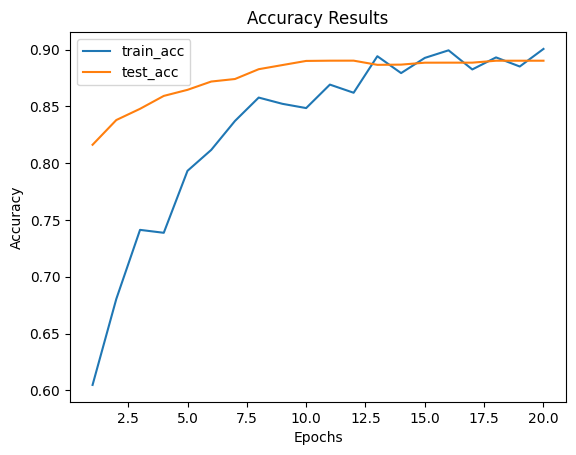

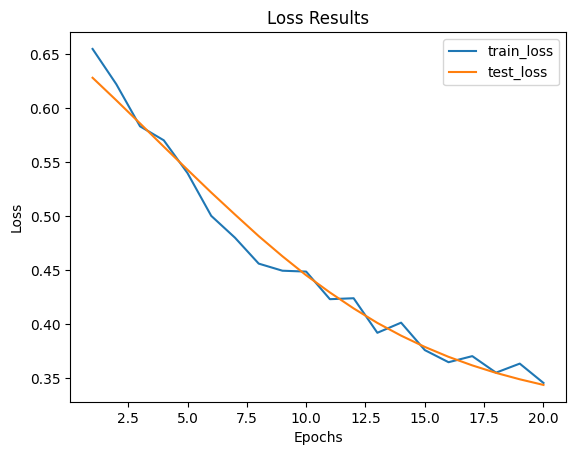

In [47]:
train_acc = history_lstm.history['accuracy']
test_acc = history_lstm.history['val_accuracy']
train_loss = history_lstm.history['loss']
test_loss = history_lstm.history['val_loss']

epoch = range(1,len(train_acc)+1) # From  1 to epoch number


plt.plot(epoch,train_acc ,label ='train_acc')
plt.plot(epoch,test_acc ,label ='test_acc')
plt.title('Accuracy Results')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epoch,train_loss ,label ='train_loss')
plt.plot(epoch,test_loss ,label ='test_loss')
plt.title('Loss Results')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

